## IMPORT LIBRARIES

In [1]:
# data wrangling 

import pandas as pd
import numpy as np
import re

# data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering

import scipy.stats as ss
import statsmodels.api as sm
from scipy.stats import anderson, mannwhitneyu, chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

# models

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KernelDensity, KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# model evaluation

from yellowbrick.model_selection import learning_curve, ValidationCurve
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, log_loss, precision_score, recall_score
from sklearn.datasets import make_classification

# filter warning

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)

## OVERVIEW

In [2]:
# load all data

df1 = pd.read_csv('data_param_label_suhu_td.csv').drop(columns = ['Unnamed: 0', 'petir', 'hujan 6 jam'])
df2 = pd.read_csv('param_label_hujan_2019.csv').drop(columns = ['Unnamed: 0'])

In [3]:
# concat all data 

df = pd.concat([df1, df2], ignore_index=True)

In [4]:
# changing dataframe columns

col_name = []
for i in df.columns.tolist():
    col = i.replace('suhu', 'temp').replace(' ', '_').lower()
    col_name.append(col)
    
df.columns = col_name

In [5]:
# rearrange dataframe columns

df.rename(columns={'waktu' : 'time', 'hujan' : 'rain'}, inplace = True)

df = df[['convective_available_potential_energy', 'k_index', 'cross_totals_index',
         'vertical_totals_index', 'lifted_index', 'showalter_index', 'temp_1000_hpa', 
         'dewpoint_1000_hpa', 'temp_850_hpa', 'dewpoint_850_hpa', 'temp_700_hpa', 'dewpoint_700_hpa', 
         'temp_500_hpa', 'dewpoint_500_hpa', 'time', 'rain']]

In [6]:
# show top 5

df.head()

,convective_available_potential_energy,k_index,cross_totals_index,vertical_totals_index,lifted_index,showalter_index,temp_1000_hpa,dewpoint_1000_hpa,temp_850_hpa,dewpoint_850_hpa,temp_700_hpa,dewpoint_700_hpa,temp_500_hpa,dewpoint_500_hpa,time,rain
0,508.22,35.4,20.1,22.9,-1.48,0.16,27.0,22.2,18.6,15.8,10.2,6.9,-4.3,11.3,2016-01-01 00:00:00,0.0
1,508.22,35.4,20.1,22.9,-1.48,0.16,27.0,22.2,18.6,15.8,10.2,6.9,-4.3,11.3,2016-01-01 12:00:00,0.0
2,952.96,32.2,19.2,22.1,-2.35,1.33,26.2,23.5,18.0,15.1,11.0,6.0,-4.1,26.1,2016-01-02 00:00:00,0.0
3,952.96,32.2,19.2,22.1,-2.35,1.33,26.2,23.5,18.0,15.1,11.0,6.0,-4.1,26.1,2016-01-02 12:00:00,0.0
4,276.15,33.7,17.1,23.1,-0.87,2.82,26.2,22.1,19.0,13.0,9.0,6.6,-4.1,34.1,2016-01-03 00:00:00,0.0


In [7]:
# check info on initial data

pd.DataFrame({'Features' : df.columns, 'dataType' : df.dtypes.values, 
              'nullvalues' : [df[i].isna().sum() for i in df.columns],
              'unique' : [df[i].nunique() for i in df.columns],
              'uniqueSample' : [list(pd.Series(df[i].unique()).sample()) for i in df.columns]}).reset_index(drop = True)

,Features,dataType,nullvalues,unique,uniqueSample
0,convective_available_potential_energy,float64,108,1072,[10.29]
1,k_index,float64,132,309,[19.1]
2,cross_totals_index,float64,132,139,[7.1]
3,vertical_totals_index,float64,132,45,[21.1]
4,lifted_index,float64,132,664,[-0.16]
5,showalter_index,float64,132,668,[2.76]
6,temp_1000_hpa,float64,112,35,[24.2]
7,dewpoint_1000_hpa,float64,112,97,[8.6]
8,temp_850_hpa,float64,112,34,[15.4]
9,dewpoint_850_hpa,float64,112,135,[-2.0]


In [8]:
# drop all missing values

df = df.dropna()

In [9]:
# change datatype

for i in df[['time','rain']]:
    if i == 'time':
        df[i] = pd.to_datetime(df[i])
    else :
        df[i] = df[i].replace({0.0 : 'No', 1.0 : 'Yes'}).astype(np.object)

In [10]:
# check info on cleaned data

pd.DataFrame({'Features' : df.columns, 'dataType' : df.dtypes.values, 
              'nullvalues' : [df[i].isna().sum() for i in df.columns],
              'unique' : [df[i].nunique() for i in df.columns],
              'uniqueSample' : [list(pd.Series(df[i].unique()).sample()) for i in df.columns]}).reset_index(drop = True)

,Features,dataType,nullvalues,unique,uniqueSample
0,convective_available_potential_energy,float64,0,967,[517.69]
1,k_index,float64,0,303,[36.0]
2,cross_totals_index,float64,0,135,[19.9]
3,vertical_totals_index,float64,0,42,[25.9]
4,lifted_index,float64,0,644,[0.96]
5,showalter_index,float64,0,645,[0.27]
6,temp_1000_hpa,float64,0,34,[26.2]
7,dewpoint_1000_hpa,float64,0,95,[17.8]
8,temp_850_hpa,float64,0,33,[19.2]
9,dewpoint_850_hpa,float64,0,135,[8.2]


In [11]:
# show cleaned data

df.head()

,convective_available_potential_energy,k_index,cross_totals_index,vertical_totals_index,lifted_index,showalter_index,temp_1000_hpa,dewpoint_1000_hpa,temp_850_hpa,dewpoint_850_hpa,temp_700_hpa,dewpoint_700_hpa,temp_500_hpa,dewpoint_500_hpa,time,rain
0,508.22,35.4,20.1,22.9,-1.48,0.16,27.0,22.2,18.6,15.8,10.2,6.9,-4.3,11.3,2016-01-01 00:00:00,No
1,508.22,35.4,20.1,22.9,-1.48,0.16,27.0,22.2,18.6,15.8,10.2,6.9,-4.3,11.3,2016-01-01 12:00:00,No
2,952.96,32.2,19.2,22.1,-2.35,1.33,26.2,23.5,18.0,15.1,11.0,6.0,-4.1,26.1,2016-01-02 00:00:00,No
3,952.96,32.2,19.2,22.1,-2.35,1.33,26.2,23.5,18.0,15.1,11.0,6.0,-4.1,26.1,2016-01-02 12:00:00,No
4,276.15,33.7,17.1,23.1,-0.87,2.82,26.2,22.1,19.0,13.0,9.0,6.6,-4.1,34.1,2016-01-03 00:00:00,No


In [12]:
# check descriptive analysis

df.describe().T

,count,mean,std,min,25%,50%,75%,max
convective_available_potential_energy,2544.0,233.733518,326.936462,0.00,0.1800,97.27,352.390,3419.86
k_index,2544.0,27.668947,9.859713,-19.70,24.3000,31.10,34.300,41.70
cross_totals_index,2544.0,17.791038,3.781396,-6.30,16.7000,18.80,20.200,24.50
vertical_totals_index,2544.0,23.475865,1.211778,19.10,22.7000,23.30,24.100,27.90
lifted_index,2544.0,-0.083581,2.533075,-29.26,-1.7025,-0.61,1.070,12.48
showalter_index,2544.0,2.281116,2.862454,-3.79,0.3400,1.54,3.300,15.52
temp_1000_hpa,2544.0,25.772248,1.031566,21.80,25.2000,26.00,26.400,28.60
dewpoint_1000_hpa,2544.0,20.445165,2.332755,3.40,19.4000,21.00,22.000,26.30
temp_850_hpa,2544.0,18.185849,0.943694,14.40,17.6000,18.20,18.800,21.20
dewpoint_850_hpa,2544.0,12.533726,3.732652,-9.00,11.4000,13.60,14.900,17.80


## FEATURE ENGINEERING

In [13]:
# create function for normality test

def normal(df):
    stat = anderson(df)[0]
    cval = anderson(df)[1][2]
    if stat < cval :
        print('NORMALLY Distributed for ' + i + ' Variable')
    else :
        print('NOT NORMALLY Distributed for ' + i + ' Variable')

In [14]:
# check normality

for i in df.drop(columns=['rain', 'time']):
    normal(df[i])

NOT NORMALLY Distributed for convective_available_potential_energy Variable
NOT NORMALLY Distributed for k_index Variable
NOT NORMALLY Distributed for cross_totals_index Variable
NOT NORMALLY Distributed for vertical_totals_index Variable
NOT NORMALLY Distributed for lifted_index Variable
NOT NORMALLY Distributed for showalter_index Variable
NOT NORMALLY Distributed for temp_1000_hpa Variable
NOT NORMALLY Distributed for dewpoint_1000_hpa Variable
NOT NORMALLY Distributed for temp_850_hpa Variable
NOT NORMALLY Distributed for dewpoint_850_hpa Variable
NOT NORMALLY Distributed for temp_700_hpa Variable
NOT NORMALLY Distributed for dewpoint_700_hpa Variable
NOT NORMALLY Distributed for temp_500_hpa Variable
NOT NORMALLY Distributed for dewpoint_500_hpa Variable


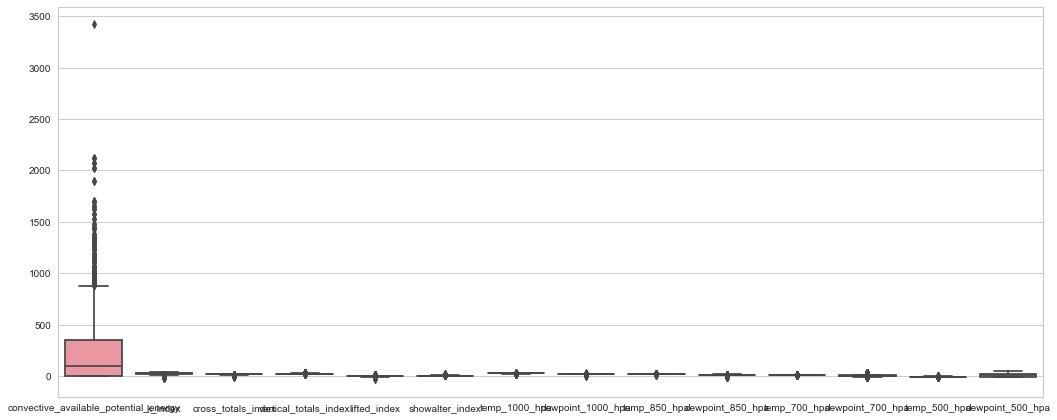

In [15]:
# check outlier with boxplot

plt.figure(figsize=(15,6))
sns.boxplot(data=df.drop(columns=['time','rain']))
plt.tight_layout()
plt.show()

In [16]:
# drop datetime feature on original dataframe

df = df.drop(columns=['time'])

In [17]:
# encode target feature

df['rain'] = LabelEncoder().fit_transform(df['rain'])

In [18]:
# split target feature

X = df.drop(columns=['rain'], axis = 1)
y = df['rain']

In [19]:
# show X & y data

print(X,y)

      convective_available_potential_energy  k_index  cross_totals_index  \
0                                    508.22     35.4                20.1   
1                                    508.22     35.4                20.1   
2                                    952.96     32.2                19.2   
3                                    952.96     32.2                19.2   
4                                    276.15     33.7                17.1   
...                                     ...      ...                 ...   
2917                                 236.40     34.5                21.5   
2918                                 706.46     30.5                19.1   
2919                                 706.46     30.5                19.1   
2920                                 119.45     32.4                18.8   
2921                                 119.45     32.4                18.8   

      vertical_totals_index  lifted_index  showalter_index  temp_1000_hpa  \
0         

In [20]:
# scale X features using RobustScaler

for i in X :
    scaler = RobustScaler()
    X[i] = scaler.fit_transform(X[i].values.reshape(-1,1))

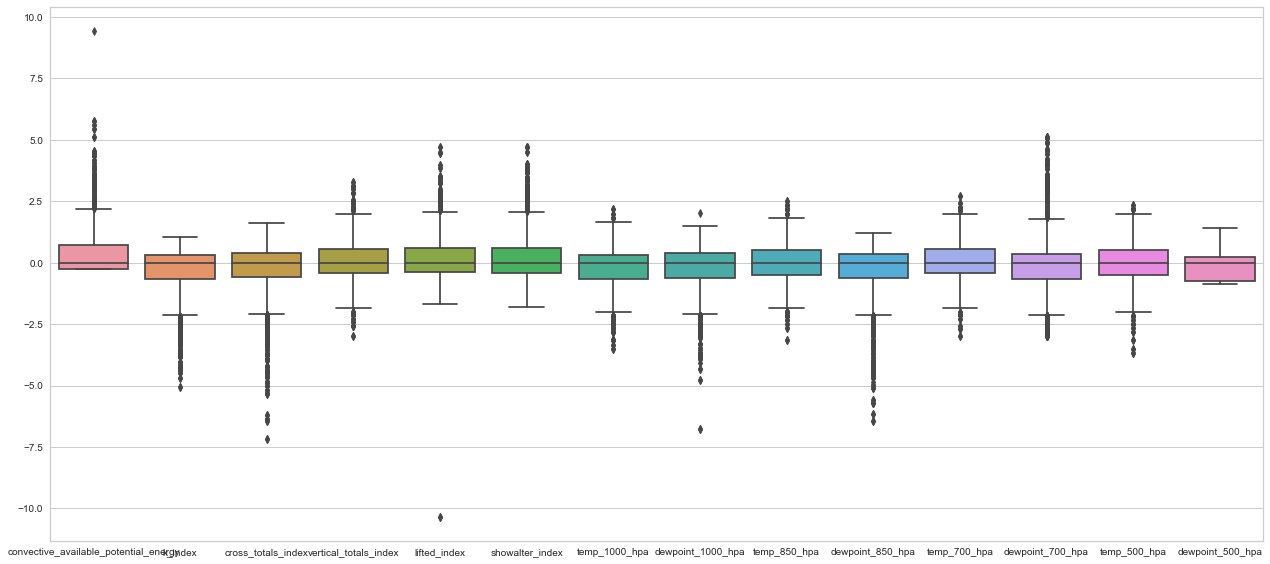

In [21]:
# check the boxplot after scaling

plt.figure(figsize=(18,8))
sns.boxplot(data=X)
plt.tight_layout()
plt.show()

In [22]:
# check scaled data

print(X, y)

      convective_available_potential_energy  k_index  cross_totals_index  \
0                                  1.166776     0.43            0.371429   
1                                  1.166776     0.43            0.371429   
2                                  2.429488     0.11            0.114286   
3                                  2.429488     0.11            0.114286   
4                                  0.507879     0.26           -0.485714   
...                                     ...      ...                 ...   
2917                               0.395020     0.34            0.771429   
2918                               1.729622    -0.06            0.085714   
2919                               1.729622    -0.06            0.085714   
2920                               0.062974     0.13            0.000000   
2921                               0.062974     0.13            0.000000   

      vertical_totals_index  lifted_index  showalter_index  temp_1000_hpa  \
0         

## MODELLING

In [23]:
# split train data and test data to 8:2 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [24]:
# setting multi-classification model

model_KNN = KNeighborsClassifier()
model_SVM = SVC()
model_GNB = GaussianNB() 
model_RFC = RandomForestClassifier()
model_XGB = XGBClassifier()

model_list = [model_KNN, model_SVM, model_GNB, model_RFC, model_XGB]

In [25]:
# function to calculate metrics

def calc_train(X_train, y_train, model):
    predictions = model.predict(X_train)
    f1 = f1_score(y_train, predictions, average ='weighted')
    accuracy = accuracy_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    recall = recall_score(y_train,predictions)
    return{
        'f1_score' : f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall' : recall 
    }

def calc_test(X_test, y_test, model):
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions, average ='weighted')
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test,predictions)
    return{
        'f1_score' : f1,
        'accuracy': accuracy,
        'precison': precision,
        'recall' : recall
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_score = calc_train(X_train, y_train, model)
    test_score = calc_test(X_test, y_test, model)
    return (train_score, test_score)

In [26]:
# calculate metrics

for i in range(0, len(model_list)):    
    def pipeline_scores(X_train, X_test, y_train, y_test):
        train_scores = []
        test_scores = []
        for j in model_list:
            train_score, test_score = calc_metrics(X_train, y_train, X_test, y_test, j)
            train_scores.append(train_score)
            test_scores.append(test_score)
            scores = {'train' : train_scores, 'test': test_scores}
        return scores

In [27]:
# classification report

report = pipeline_scores(X_train, X_test, y_train, y_test)

In [28]:
# check model train & test scores

model = 'KNN', 'SVM', 'GNB', 'RFC', 'XGB'

for i in range(0, len(model)):
    print('TRAIN', model[i], '=', report['train'][i])
    print('TEST ', model[i], '=', report['test'][i])
    print('\n')

TRAIN KNN = {'f1_score': 0.8000709369135401, 'accuracy': 0.803931203931204, 'precision': 0.7250437828371279, 'recall': 0.6310975609756098}
TEST  KNN = {'f1_score': 0.6795480816160314, 'accuracy': 0.68762278978389, 'precison': 0.5921052631578947, 'recall': 0.48128342245989303}


TRAIN SVM = {'f1_score': 0.7131379559037063, 'accuracy': 0.742014742014742, 'precision': 0.6978851963746223, 'recall': 0.3521341463414634}
TEST  SVM = {'f1_score': 0.6811811779545968, 'accuracy': 0.7131630648330058, 'precison': 0.7303370786516854, 'recall': 0.34759358288770054}


TRAIN GNB = {'f1_score': 0.6441394416328838, 'accuracy': 0.6363636363636364, 'precision': 0.46568627450980393, 'recall': 0.8689024390243902}
TEST  GNB = {'f1_score': 0.6440247038995386, 'accuracy': 0.6444007858546169, 'precison': 0.5092592592592593, 'recall': 0.8823529411764706}


TRAIN RFC = {'f1_score': 0.8786114969208921, 'accuracy': 0.8805896805896806, 'precision': 0.8542024013722127, 'recall': 0.7591463414634146}
TEST  RFC = {'f1_s

In [29]:
# check overfitting with cross-validation

kfold = []
for i in range(0, len(model)):
    cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
    fold = cross_val_score(model_list[i], X_train, y_train, cv=cv, scoring='recall')
    print(model[i], 'CROSS VALIDATION \n', fold)
    print('\n')
    kfold.append(fold.mean())

KNN CROSS VALIDATION 
 [0.46969697 0.60606061 0.46969697 0.48484848 0.46969697 0.53030303
 0.49230769 0.47692308 0.46153846 0.52307692]


SVM CROSS VALIDATION 
 [0.37878788 0.40909091 0.31818182 0.33333333 0.3030303  0.37878788
 0.29230769 0.32307692 0.27692308 0.29230769]


GNB CROSS VALIDATION 
 [0.86363636 0.92424242 0.92424242 0.8030303  0.8030303  0.92424242
 0.84615385 0.90769231 0.87692308 0.81538462]


RFC CROSS VALIDATION 
 [0.54545455 0.59090909 0.42424242 0.46969697 0.45454545 0.54545455
 0.44615385 0.49230769 0.44615385 0.47692308]


XGB CROSS VALIDATION 
 [0.57575758 0.56060606 0.45454545 0.48484848 0.46969697 0.56060606
 0.49230769 0.50769231 0.50769231 0.41538462]




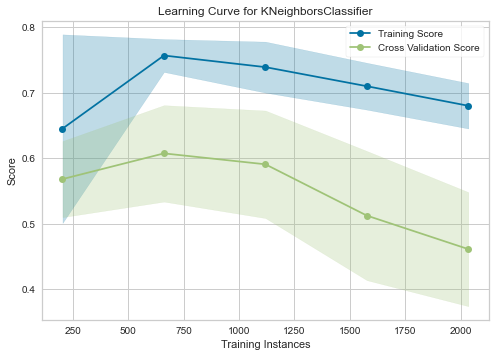

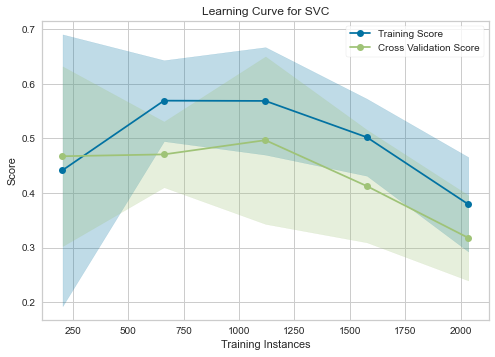

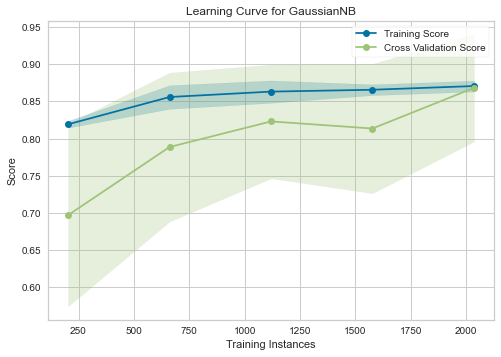

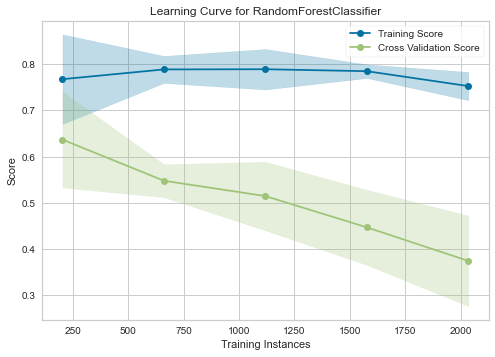

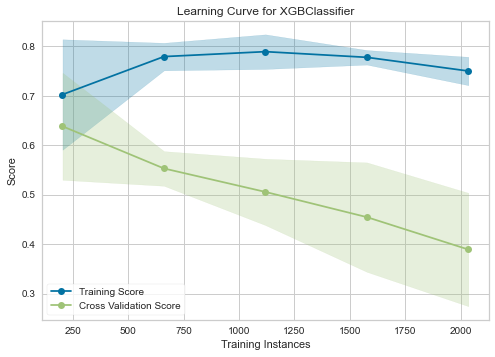

In [30]:
# plot learning curve

for i in model_list:
    learning_curve(i, X, y, scoring='recall')
    plt.show()

In [31]:
# check train and cross-validation score

Xtrain_score = []
kfold_score = []

for i in range(0, len(kfold)):
    kfold_score.append(kfold[i])
    Xtrain_score.append(report['train'][i]['recall'])

# print dataframe

pd.DataFrame({'Model' : model, 
              'Normal': Xtrain_score,
              'Kfold ': kfold_score})

,Model,Normal,Kfold
0,KNN,0.631098,0.498415
1,SVM,0.352134,0.330583
2,GNB,0.868902,0.868858
3,RFC,0.759146,0.489184
4,XGB,0.765244,0.502914



               precision    recall  f1-score   support

    Not Rain       0.73      0.81      0.77       322
        Rain       0.59      0.48      0.53       187

    accuracy                           0.69       509
   macro avg       0.66      0.64      0.65       509
weighted avg       0.68      0.69      0.68       509



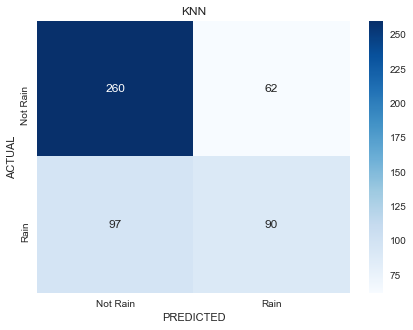




               precision    recall  f1-score   support

    Not Rain       0.71      0.93      0.80       322
        Rain       0.73      0.35      0.47       187

    accuracy                           0.71       509
   macro avg       0.72      0.64      0.64       509
weighted avg       0.72      0.71      0.68       509



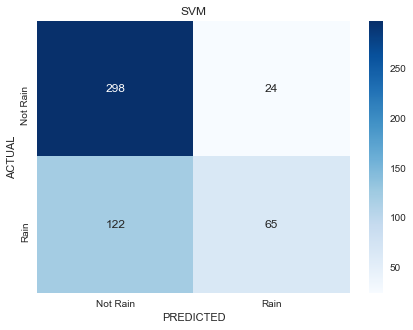




               precision    recall  f1-score   support

    Not Rain       0.88      0.51      0.64       322
        Rain       0.51      0.88      0.65       187

    accuracy                           0.64       509
   macro avg       0.70      0.69      0.64       509
weighted avg       0.74      0.64      0.64       509



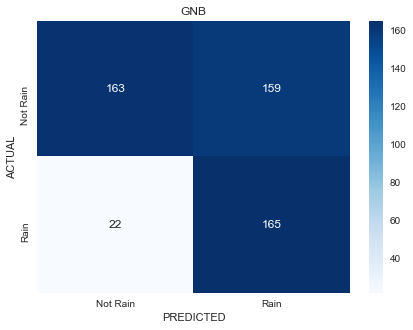




               precision    recall  f1-score   support

    Not Rain       0.79      0.82      0.80       322
        Rain       0.67      0.62      0.64       187

    accuracy                           0.75       509
   macro avg       0.73      0.72      0.72       509
weighted avg       0.74      0.75      0.74       509



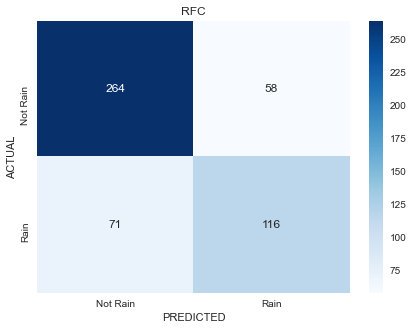




               precision    recall  f1-score   support

    Not Rain       0.78      0.81      0.80       322
        Rain       0.66      0.61      0.63       187

    accuracy                           0.74       509
   macro avg       0.72      0.71      0.71       509
weighted avg       0.74      0.74      0.74       509



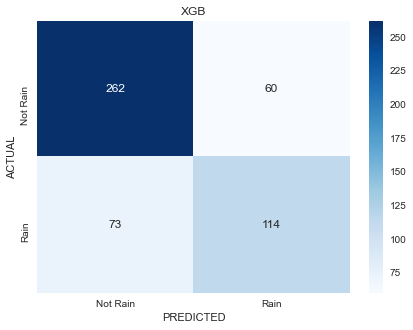

In [32]:
# model predict & evaluation

conf_matrix = []
for i in range(0, (len(model_list))):
    labels = ['Not Rain', 'Rain']
    y_pred = model_list[i].predict(X_test)
    conf_matrix.append(confusion_matrix(y_test, y_pred))
    print('\n', classification_report(y_test, y_pred, target_names = labels))  
    
    f, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(conf_matrix[i], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.title(model[i])
    plt.xlabel('PREDICTED')
    plt.ylabel('ACTUAL')
    plt.show()
    print('\n')

## FEATURE ENGINEERING - FEATURE SELECTION

[0.07492886 0.08685447 0.07861463 0.06532174 0.07257403 0.07676744
 0.05981512 0.09014985 0.05837633 0.08415354 0.05208457 0.06226664
 0.05452418 0.0835686 ]


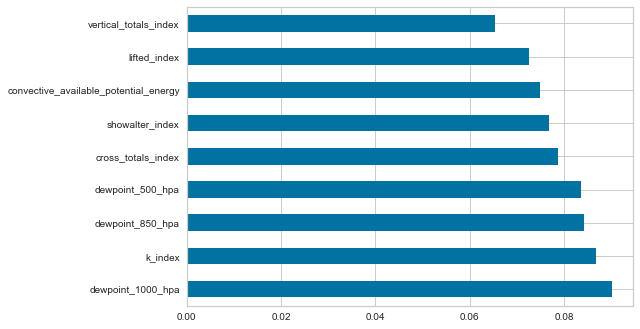

In [33]:
# feature importances using Tree Based Classifier

tree = ExtraTreesClassifier()
tree.fit(X,y)
print(tree.feature_importances_)

# plot graph of feature importances for better visualization

feat_importances = pd.Series(tree.feature_importances_, index=X.columns)
feat_importances.nlargest(9).plot(kind = 'barh')
plt.show()

In [34]:
# get new columns from feature importances

feat_col = feat_importances.nlargest(9).index.tolist()
feat_tgt = pd.DataFrame(df['rain'])

In [35]:
# get new dataframe

df_new = pd.concat([df[feat_col], feat_tgt], axis=1)

In [36]:
# show top 5 

df_new.head()

,dewpoint_1000_hpa,k_index,dewpoint_850_hpa,dewpoint_500_hpa,cross_totals_index,showalter_index,convective_available_potential_energy,lifted_index,vertical_totals_index,rain
0,22.2,35.4,15.8,11.3,20.1,0.16,508.22,-1.48,22.9,0
1,22.2,35.4,15.8,11.3,20.1,0.16,508.22,-1.48,22.9,0
2,23.5,32.2,15.1,26.1,19.2,1.33,952.96,-2.35,22.1,0
3,23.5,32.2,15.1,26.1,19.2,1.33,952.96,-2.35,22.1,0
4,22.1,33.7,13.0,34.1,17.1,2.82,276.15,-0.87,23.1,0


## MODELLING WITH SELECTED FEATURE

In [37]:
# split target feature

X1 = df_new.drop(columns=['rain'], axis = 1)
y1 = df_new['rain']

In [38]:
# scale X features using RobustScaler

for i in X1 :
    scaler = RobustScaler()
    X1[i] = scaler.fit_transform(X1[i].values.reshape(-1,1))

In [39]:
# split train data and test data to 8:2 ratio

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size = 0.8, random_state = 42)

In [40]:
# calculate metrics

for i in range(0, len(model_list)):    
    def pipeline_scores(X1_train, X1_test, y1_train, y1_test):
        train_scores = []
        test_scores = []
        for j in model_list:
            train_score, test_score = calc_metrics(X1_train, y1_train, X1_test, y1_test, j)
            train_scores.append(train_score)
            test_scores.append(test_score)
            scores = {'train' : train_scores, 'test': test_scores}
        return scores

In [41]:
# classification report

report1 = pipeline_scores(X1_train, X1_test, y1_train, y1_test)

In [42]:
# check model train & test scores

model = 'KNN', 'SVM', 'GNB', 'RFC', 'XGB'

for i in range(0, len(model)):
    print('TRAIN', model[i], '=', report1['train'][i])
    print('TEST ', model[i], '=', report1['test'][i])
    print('\n')

TRAIN KNN = {'f1_score': 0.785034711283932, 'accuracy': 0.7886977886977887, 'precision': 0.6948275862068966, 'recall': 0.614329268292683}
TEST  KNN = {'f1_score': 0.6857576604451558, 'accuracy': 0.6915520628683693, 'precison': 0.59375, 'recall': 0.5080213903743316}


TRAIN SVM = {'f1_score': 0.7152288728714677, 'accuracy': 0.7380835380835381, 'precision': 0.6614173228346457, 'recall': 0.38414634146341464}
TEST  SVM = {'f1_score': 0.7010287985955315, 'accuracy': 0.7229862475442044, 'precison': 0.7129629629629629, 'recall': 0.4117647058823529}


TRAIN GNB = {'f1_score': 0.637415810008282, 'accuracy': 0.6304668304668305, 'precision': 0.46153846153846156, 'recall': 0.8780487804878049}
TEST  GNB = {'f1_score': 0.6402186348537569, 'accuracy': 0.6424361493123772, 'precison': 0.5075075075075075, 'recall': 0.9037433155080213}


TRAIN RFC = {'f1_score': 0.8793155631001635, 'accuracy': 0.8805896805896806, 'precision': 0.8401976935749588, 'recall': 0.7774390243902439}
TEST  RFC = {'f1_score': 0.73

In [43]:
# check overfitting with cross-validation

kfold = []
for i in range(0, len(model)):
    cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
    fold = cross_val_score(model_list[i], X1_train, y1_train, cv=cv, scoring='recall')
    print(model[i], 'CROSS VALIDATION \n', fold)
    print('\n')
    kfold.append(fold.mean())

KNN CROSS VALIDATION 
 [0.53030303 0.43939394 0.46969697 0.43939394 0.53030303 0.54545455
 0.46153846 0.46153846 0.47692308 0.46153846]


SVM CROSS VALIDATION 
 [0.34848485 0.37878788 0.43939394 0.39393939 0.39393939 0.36363636
 0.33846154 0.35384615 0.33846154 0.32307692]


GNB CROSS VALIDATION 
 [0.89393939 0.93939394 0.92424242 0.78787879 0.8030303  0.92424242
 0.90769231 0.92307692 0.89230769 0.84615385]


RFC CROSS VALIDATION 
 [0.56060606 0.57575758 0.43939394 0.45454545 0.42424242 0.54545455
 0.47692308 0.49230769 0.52307692 0.53846154]


XGB CROSS VALIDATION 
 [0.54545455 0.59090909 0.45454545 0.48484848 0.46969697 0.53030303
 0.50769231 0.49230769 0.53846154 0.44615385]




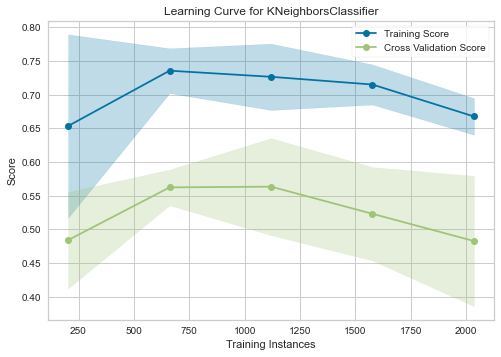

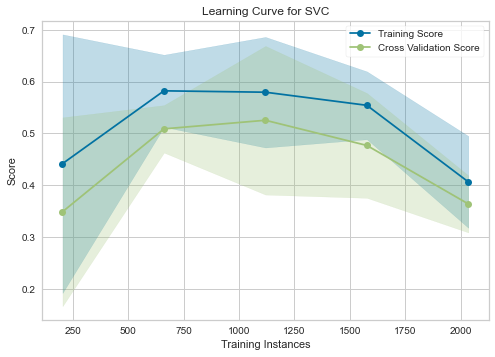

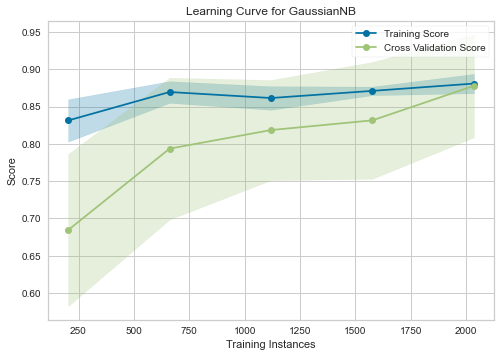

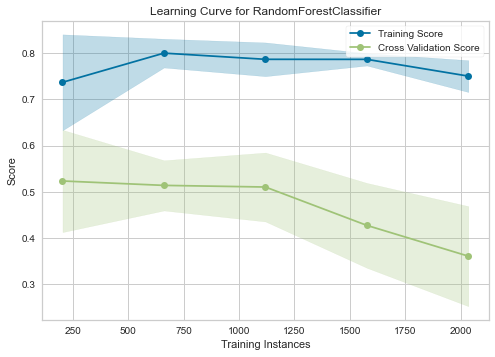

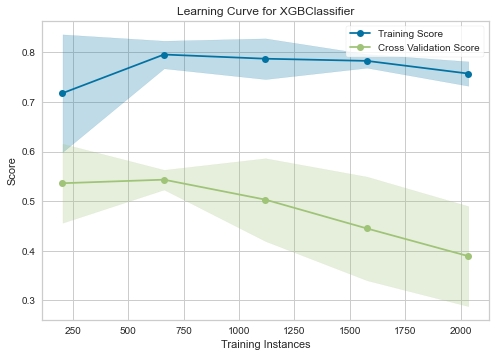

In [44]:
# plot learning curve

for i in model_list:
    learning_curve(i, X1, y1, scoring='recall')
    plt.show()

In [45]:
# check train and cross-validation score

Xtrain_score = []
kfold_score = []

for i in range(0, len(kfold)):
    kfold_score.append(kfold[i])
    Xtrain_score.append(report1['train'][i]['recall'])

# print dataframe

pd.DataFrame({'Model' : model, 
              'Normal': Xtrain_score,
              'Kfold ': kfold_score})

,Model,Normal,Kfold
0,KNN,0.614329,0.481608
1,SVM,0.384146,0.367203
2,GNB,0.878049,0.884196
3,RFC,0.777439,0.503077
4,XGB,0.762195,0.506037



               precision    recall  f1-score   support

    Not Rain       0.74      0.80      0.77       322
        Rain       0.59      0.51      0.55       187

    accuracy                           0.69       509
   macro avg       0.67      0.65      0.66       509
weighted avg       0.68      0.69      0.69       509



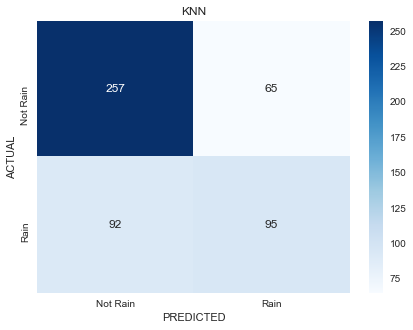




               precision    recall  f1-score   support

    Not Rain       0.73      0.90      0.80       322
        Rain       0.71      0.41      0.52       187

    accuracy                           0.72       509
   macro avg       0.72      0.66      0.66       509
weighted avg       0.72      0.72      0.70       509



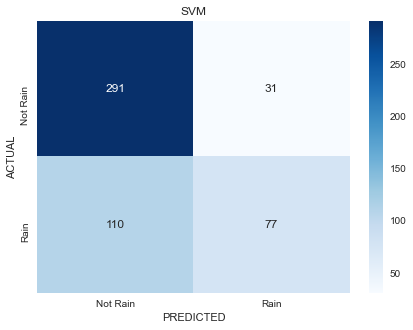




               precision    recall  f1-score   support

    Not Rain       0.90      0.49      0.63       322
        Rain       0.51      0.90      0.65       187

    accuracy                           0.64       509
   macro avg       0.70      0.70      0.64       509
weighted avg       0.75      0.64      0.64       509



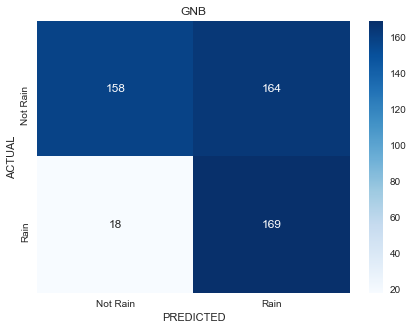




               precision    recall  f1-score   support

    Not Rain       0.78      0.81      0.79       322
        Rain       0.65      0.61      0.63       187

    accuracy                           0.73       509
   macro avg       0.71      0.71      0.71       509
weighted avg       0.73      0.73      0.73       509



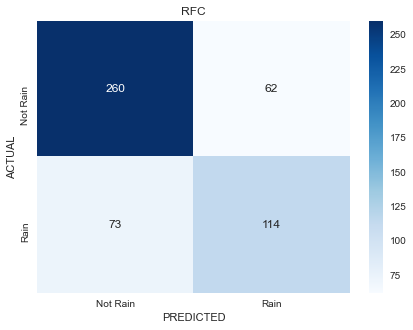




               precision    recall  f1-score   support

    Not Rain       0.79      0.81      0.80       322
        Rain       0.65      0.62      0.64       187

    accuracy                           0.74       509
   macro avg       0.72      0.71      0.72       509
weighted avg       0.74      0.74      0.74       509



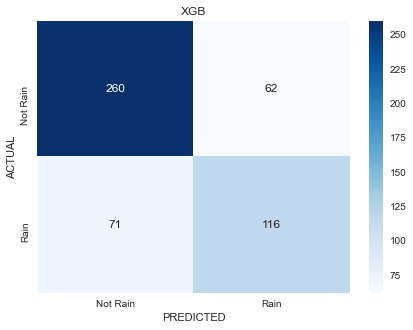

In [46]:
# model predict & evaluation

conf_matrix = []
for i in range(0, (len(model_list))):
    labels = ['Not Rain', 'Rain']
    y1_pred = model_list[i].predict(X1_test)
    conf_matrix.append(confusion_matrix(y1_test, y1_pred))
    print('\n', classification_report(y1_test, y1_pred, target_names = labels))  
    
    f, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(conf_matrix[i], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.title(model[i])
    plt.xlabel('PREDICTED')
    plt.ylabel('ACTUAL')
    plt.show()
    print('\n')

## MODELLING WITH OVERSAMPLED DATA

In [47]:
# Oversampling with SMOTE

X_train_sm, y_train_sm = SMOTE(random_state=42).fit_sample(X_train, y_train)

In [48]:
# setting multi-classification SMOTE model

model_KNN_sm = KNeighborsClassifier().fit(X_train_sm, y_train_sm)
model_SVM_sm = SVC().fit(X_train_sm, y_train_sm)
model_GNB_sm = GaussianNB().fit(X_train_sm, y_train_sm)
model_RFC_sm = RandomForestClassifier().fit(X_train_sm, y_train_sm)
model_XGB_sm = XGBClassifier().fit(X_train_sm, y_train_sm)

model_list_sm = [model_KNN_sm, model_SVM_sm, model_GNB_sm, model_RFC_sm, model_XGB_sm]

In [49]:
for i in range(0, len(model_list_sm)):
    def pipeline_scores(X_train_sm, X_test, y_train_sm, y_test):
        train_scores = []
        test_scores = []
        for j in model_list:
            train_score, test_score = calc_metrics(X_train_sm, y_train_sm, X_test, y_test, j)
            train_scores.append(train_score)
            test_scores.append(test_score)
            scores = {'train' : train_scores, 'test': test_scores}
        return scores

In [50]:
# classification report

report_sm = pipeline_scores(X_train_sm, X_test, y_train_sm, y_test)

In [51]:
# check model train & test scores

model = 'KNN', 'SVM', 'GNB', 'RFC', 'XGB'

for i in range(0, len(model)):
    print('TRAIN', model[i], '=', report_sm['train'][i])
    print('TEST ', model[i], '=', report_sm['test'][i])
    print('\n')

TRAIN KNN = {'f1_score': 0.8323158410494654, 'accuracy': 0.8335750543872371, 'precision': 0.784301606922126, 'recall': 0.9202320522117476}
TEST  KNN = {'f1_score': 0.6871757545752399, 'accuracy': 0.6817288801571709, 'precison': 0.5523012552301255, 'recall': 0.7058823529411765}


TRAIN SVM = {'f1_score': 0.7399086008102171, 'accuracy': 0.7436548223350253, 'precision': 0.6964912280701754, 'recall': 0.8636693255982596}
TEST  SVM = {'f1_score': 0.6923645883557066, 'accuracy': 0.68762278978389, 'precison': 0.55, 'recall': 0.8235294117647058}


TRAIN GNB = {'f1_score': 0.6942256514526387, 'accuracy': 0.705221174764322, 'precision': 0.6487907465825447, 'recall': 0.8948513415518492}
TEST  GNB = {'f1_score': 0.645008397897422, 'accuracy': 0.6463654223968566, 'precison': 0.5106382978723404, 'recall': 0.8983957219251337}


TRAIN RFC = {'f1_score': 0.9118576231410136, 'accuracy': 0.9118926758520667, 'precision': 0.896094839609484, 'recall': 0.9318346627991299}
TEST  RFC = {'f1_score': 0.7339267934

In [52]:
# check overfitting with cross-validation

kfold = []
for i in range(0, len(model)):
    cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
    fold = cross_val_score(model_list[i], X_train_sm, y_train_sm, cv=cv, scoring='recall')
    print(model[i], 'CROSS VALIDATION \n', fold)
    print('\n')
    kfold.append(fold.mean())

KNN CROSS VALIDATION 
 [0.85507246 0.85507246 0.91304348 0.93478261 0.79710145 0.88405797
 0.86956522 0.87681159 0.92028986 0.83941606]


SVM CROSS VALIDATION 
 [0.86956522 0.86231884 0.84782609 0.84057971 0.82608696 0.84057971
 0.82608696 0.88405797 0.87681159 0.83941606]


GNB CROSS VALIDATION 
 [0.9057971  0.88405797 0.86956522 0.95652174 0.89130435 0.85507246
 0.89130435 0.89130435 0.89855072 0.90510949]


RFC CROSS VALIDATION 
 [0.77536232 0.74637681 0.84057971 0.76086957 0.74637681 0.84057971
 0.76086957 0.75362319 0.78985507 0.72992701]


XGB CROSS VALIDATION 
 [0.79710145 0.75362319 0.84057971 0.75362319 0.78985507 0.86956522
 0.77536232 0.76086957 0.7826087  0.71532847]




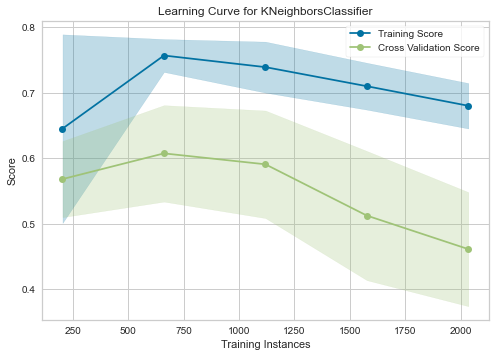

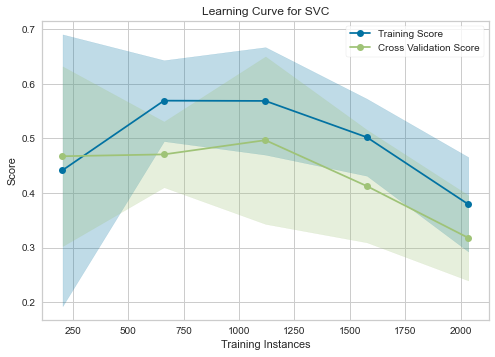

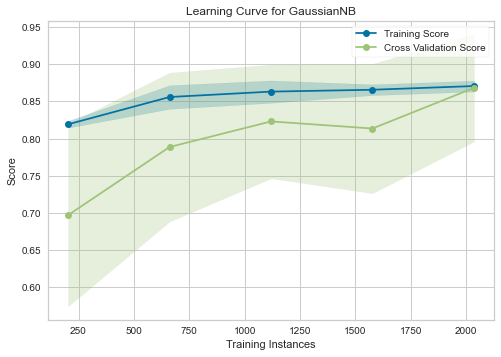

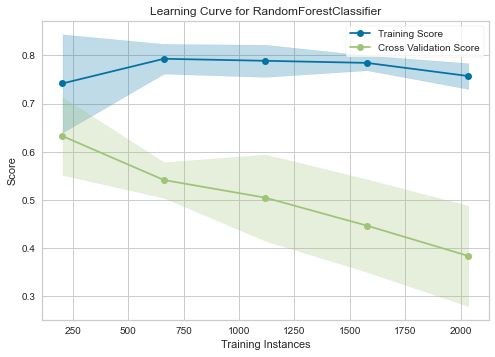

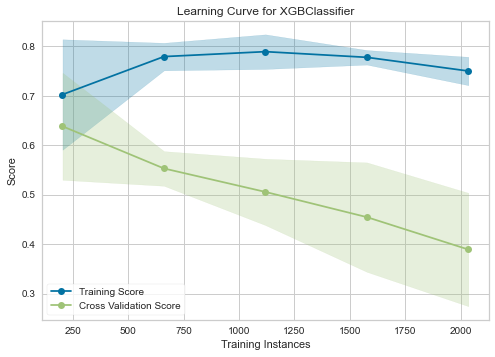

In [53]:
# plot learning curve

for i in model_list_sm:
    learning_curve(i, X, y, scoring='recall')
    plt.show()

In [54]:
# check train and cross-validation score

Xtrain_score = []
kfold_score = []

for i in range(0, len(kfold)):
    kfold_score.append(kfold[i])
    Xtrain_score.append(report_sm['train'][i]['recall'])

# print dataframe

pd.DataFrame({'Model' : model, 
              'Normal': Xtrain_score,
              'Kfold ': kfold_score})

,Model,Normal,Kfold
0,KNN,0.920232,0.874521
1,SVM,0.863669,0.851333
2,GNB,0.894851,0.894859
3,RFC,0.931835,0.774442
4,XGB,0.912980,0.783852



               precision    recall  f1-score   support

    Not Rain       0.80      0.67      0.73       322
        Rain       0.55      0.71      0.62       187

    accuracy                           0.68       509
   macro avg       0.67      0.69      0.67       509
weighted avg       0.71      0.68      0.69       509



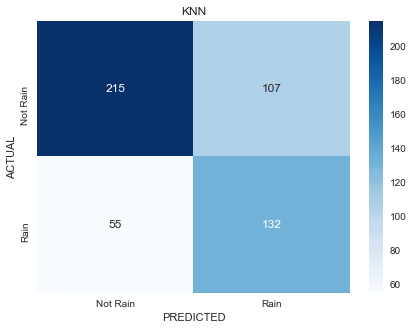




               precision    recall  f1-score   support

    Not Rain       0.86      0.61      0.71       322
        Rain       0.55      0.82      0.66       187

    accuracy                           0.69       509
   macro avg       0.70      0.72      0.69       509
weighted avg       0.74      0.69      0.69       509



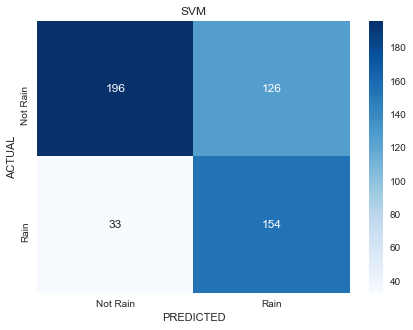




               precision    recall  f1-score   support

    Not Rain       0.89      0.50      0.64       322
        Rain       0.51      0.90      0.65       187

    accuracy                           0.65       509
   macro avg       0.70      0.70      0.65       509
weighted avg       0.75      0.65      0.65       509



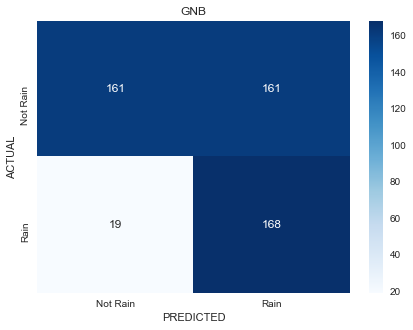




               precision    recall  f1-score   support

    Not Rain       0.79      0.79      0.79       322
        Rain       0.64      0.64      0.64       187

    accuracy                           0.73       509
   macro avg       0.71      0.71      0.71       509
weighted avg       0.73      0.73      0.73       509



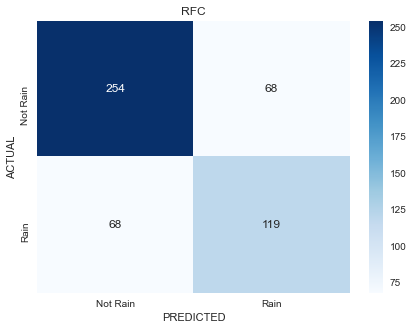




               precision    recall  f1-score   support

    Not Rain       0.78      0.80      0.79       322
        Rain       0.64      0.62      0.63       187

    accuracy                           0.73       509
   macro avg       0.71      0.71      0.71       509
weighted avg       0.73      0.73      0.73       509



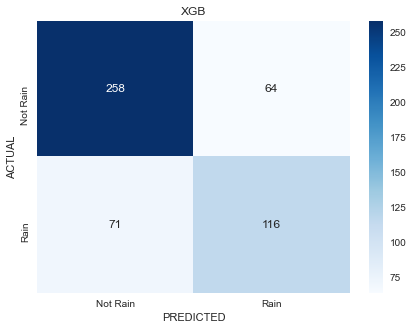

In [55]:
# model predict & evaluation with SMOTE

conf_matrix = []
for i in range(0, (len(model_list_sm))):
    labels = ['Not Rain', 'Rain']
    y_pred = model_list_sm[i].predict(X_test)
    conf_matrix.append(confusion_matrix(y_test, y_pred))
    print('\n', classification_report(y_test, y_pred, target_names = labels))  
    
    f, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(conf_matrix[i], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.title(model[i])
    plt.xlabel('PREDICTED')
    plt.ylabel('ACTUAL')
    plt.show()
    print('\n')

## MODELLING WITH SELECTED FEATURE AND SMOTE

In [56]:
# Oversampling with SMOTE

X1_train_sm, y1_train_sm = SMOTE(random_state=42).fit_sample(X1_train, y1_train)

In [57]:
# setting multi-classification SMOTE model

model_KNN_sm1 = KNeighborsClassifier().fit(X1_train_sm, y1_train_sm)
model_SVM_sm1 = SVC().fit(X1_train_sm, y1_train_sm)
model_GNB_sm1 = GaussianNB().fit(X1_train_sm, y1_train_sm)
model_RFC_sm1 = RandomForestClassifier().fit(X1_train_sm, y1_train_sm)
model_XGB_sm1 = XGBClassifier().fit(X1_train_sm, y1_train_sm)

model_list_sm1 = [model_KNN_sm1, model_SVM_sm1, model_GNB_sm1, model_RFC_sm1, model_XGB_sm1]

In [58]:
# calculate metrics

for i in range(0, len(model_list)):    
    def pipeline_scores(X1_train_sm, X1_test, y1_train_sm, y1_test):
        train_scores = []
        test_scores = []
        for j in model_list:
            train_score, test_score = calc_metrics(X1_train_sm, y1_train_sm, X1_test, y1_test, j)
            train_scores.append(train_score)
            test_scores.append(test_score)
            scores = {'train' : train_scores, 'test': test_scores}
        return scores

In [59]:
# classification report

report_sm1 = pipeline_scores(X1_train_sm, X1_test, y1_train_sm, y1_test)

In [60]:
# check model train & test scores

model = 'KNN', 'SVM', 'GNB', 'RFC', 'XGB'

for i in range(0, len(model)):
    print('TRAIN', model[i], '=', report_sm1['train'][i])
    print('TEST ', model[i], '=', report_sm1['test'][i])
    print('\n')

TRAIN KNN = {'f1_score': 0.829371543924786, 'accuracy': 0.8306744017403916, 'precision': 0.7814814814814814, 'recall': 0.9180565627266135}
TEST  KNN = {'f1_score': 0.6796872846659185, 'accuracy': 0.6738703339882122, 'precison': 0.5421686746987951, 'recall': 0.7219251336898396}


TRAIN SVM = {'f1_score': 0.7227397134616697, 'accuracy': 0.7266134880348079, 'precision': 0.6832844574780058, 'recall': 0.8448150833937635}
TEST  SVM = {'f1_score': 0.6864942915630539, 'accuracy': 0.6817288801571709, 'precison': 0.5444839857651246, 'recall': 0.8181818181818182}


TRAIN GNB = {'f1_score': 0.6874900579417333, 'accuracy': 0.7001450326323423, 'precision': 0.6427094105480868, 'recall': 0.9013778100072516}
TEST  GNB = {'f1_score': 0.6304448498456358, 'accuracy': 0.6345776031434185, 'precison': 0.501466275659824, 'recall': 0.9144385026737968}


TRAIN RFC = {'f1_score': 0.9118576231410136, 'accuracy': 0.9118926758520667, 'precision': 0.896094839609484, 'recall': 0.9318346627991299}
TEST  RFC = {'f1_sco

In [61]:
# check overfitting with cross-validation

kfold = []
for i in range(0, len(model)):
    cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state=0)
    fold = cross_val_score(model_list[i], X1_train_sm, y1_train_sm, cv=cv, scoring='recall')
    print(model[i], 'CROSS VALIDATION \n', fold)
    print('\n')
    kfold.append(fold.mean())

KNN CROSS VALIDATION 
 [0.84057971 0.84782609 0.89855072 0.84782609 0.80434783 0.88405797
 0.89855072 0.83333333 0.89855072 0.86131387]


SVM CROSS VALIDATION 
 [0.85507246 0.84782609 0.84057971 0.87681159 0.84782609 0.79710145
 0.82608696 0.85507246 0.84057971 0.81751825]


GNB CROSS VALIDATION 
 [0.89855072 0.89130435 0.89855072 0.94202899 0.89130435 0.87681159
 0.89855072 0.88405797 0.92028986 0.91240876]


RFC CROSS VALIDATION 
 [0.74637681 0.7826087  0.82608696 0.76086957 0.74637681 0.79710145
 0.75362319 0.73913043 0.76086957 0.69343066]


XGB CROSS VALIDATION 
 [0.77536232 0.77536232 0.84057971 0.73188406 0.76811594 0.79710145
 0.7826087  0.7173913  0.75362319 0.75182482]




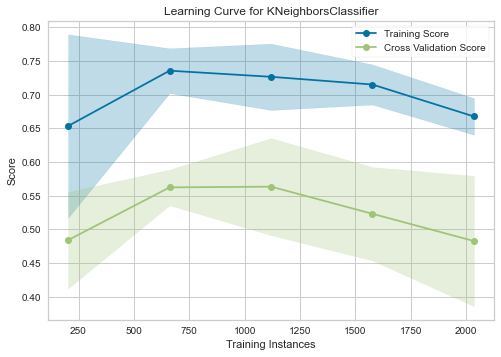

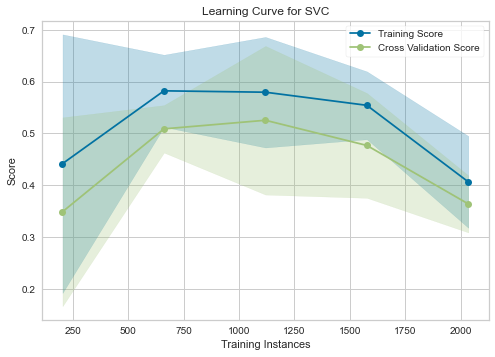

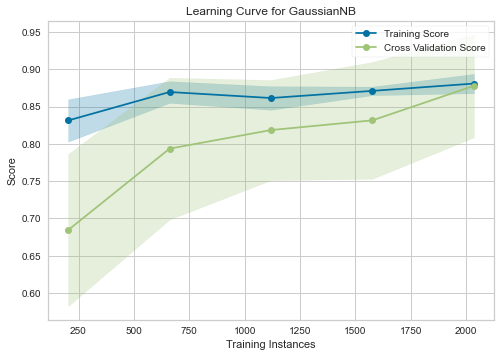

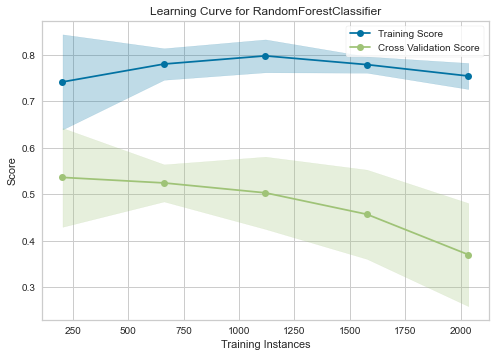

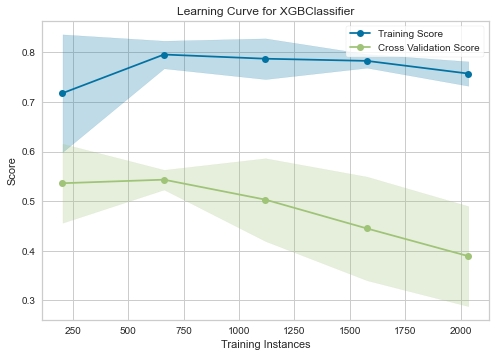

In [62]:
# plot learning curve

for i in model_list_sm:
    learning_curve(i, X1, y1, scoring='recall')
    plt.show()

In [63]:
# check train and cross-validation score

Xtrain_score = []
kfold_score = []

for i in range(0, len(kfold)):
    kfold_score.append(kfold[i])
    Xtrain_score.append(report_sm1['train'][i]['recall'])

# print dataframe

pd.DataFrame({'Model' : model, 
              'Normal': Xtrain_score,
              'Kfold ': kfold_score})

,Model,Normal,Kfold
0,KNN,0.918057,0.861494
1,SVM,0.844815,0.840447
2,GNB,0.901378,0.901386
3,RFC,0.931835,0.760647
4,XGB,0.927484,0.769385



               precision    recall  f1-score   support

    Not Rain       0.80      0.65      0.71       322
        Rain       0.54      0.72      0.62       187

    accuracy                           0.67       509
   macro avg       0.67      0.68      0.67       509
weighted avg       0.71      0.67      0.68       509



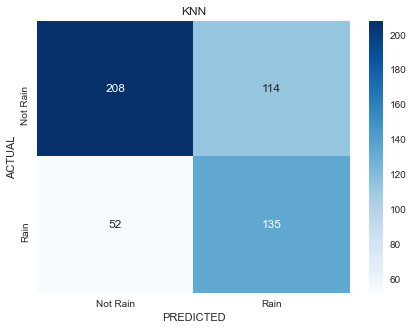




               precision    recall  f1-score   support

    Not Rain       0.85      0.60      0.71       322
        Rain       0.54      0.82      0.65       187

    accuracy                           0.68       509
   macro avg       0.70      0.71      0.68       509
weighted avg       0.74      0.68      0.69       509



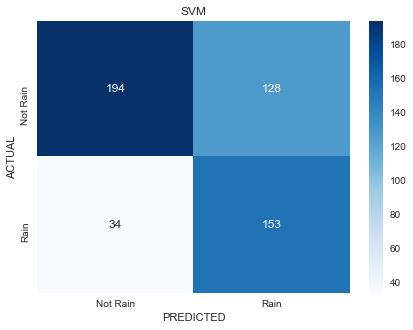




               precision    recall  f1-score   support

    Not Rain       0.90      0.47      0.62       322
        Rain       0.50      0.91      0.65       187

    accuracy                           0.63       509
   macro avg       0.70      0.69      0.63       509
weighted avg       0.76      0.63      0.63       509



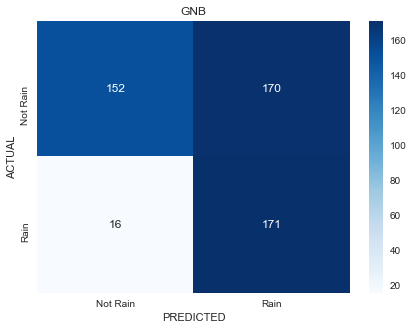




               precision    recall  f1-score   support

    Not Rain       0.79      0.77      0.78       322
        Rain       0.62      0.64      0.63       187

    accuracy                           0.72       509
   macro avg       0.70      0.71      0.71       509
weighted avg       0.73      0.72      0.73       509



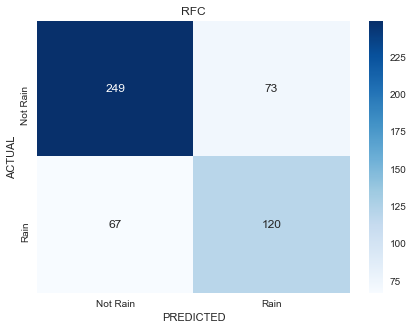




               precision    recall  f1-score   support

    Not Rain       0.79      0.77      0.78       322
        Rain       0.62      0.64      0.63       187

    accuracy                           0.72       509
   macro avg       0.70      0.71      0.71       509
weighted avg       0.73      0.72      0.73       509



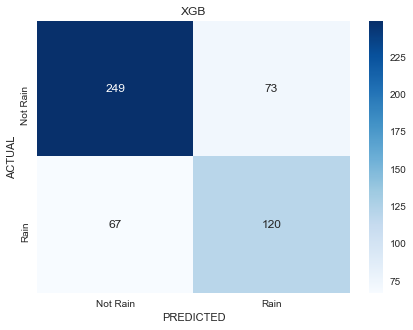

In [64]:
# model predict & evaluation

conf_matrix = []
for i in range(0, (len(model_list))):
    labels = ['Not Rain', 'Rain']
    y1_pred_sm = model_list_sm1[i].predict(X1_test)
    conf_matrix.append(confusion_matrix(y1_test, y1_pred_sm))
    print('\n', classification_report(y1_test, y1_pred_sm, target_names = labels))  
    
    f, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(conf_matrix[i], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.title(model[i])
    plt.xlabel('PREDICTED')
    plt.ylabel('ACTUAL')
    plt.show()
    print('\n')

## SUMMARY

In [65]:
# summary of test attempts

test_report = report['test'], report1['test'], report_sm['test'], report_sm1['test']

test_name = 'Normal Modelling', 'Modelling With Selected Features', 'Modelling With SMOTE', 'Modelling With Selected Features & SMOTE'

for i in range(len(test_report)):
    print(f'\n{test_name[i]}\n', pd.DataFrame(test_report[i], index=model).T, '\n')


Normal Modelling
                KNN       SVM       GNB       RFC       XGB
f1_score  0.679548  0.681181  0.644025  0.744506  0.736584
accuracy  0.687623  0.713163  0.644401  0.746562  0.738703
precison  0.592105  0.730337  0.509259  0.666667  0.655172
recall    0.481283  0.347594  0.882353  0.620321  0.609626 


Modelling With Selected Features
                KNN       SVM       GNB       RFC       XGB
f1_score  0.685758  0.701029  0.640219  0.732983  0.737283
accuracy  0.691552  0.722986  0.642436  0.734774  0.738703
precison  0.593750  0.712963  0.507508  0.647727  0.651685
recall    0.508021  0.411765  0.903743  0.609626  0.620321 


Modelling With SMOTE
                KNN       SVM       GNB       RFC       XGB
f1_score  0.687176  0.692365  0.645008  0.733927  0.733671
accuracy  0.681729  0.687623  0.646365  0.732809  0.734774
precison  0.552301  0.550000  0.510638  0.630769  0.644444
recall    0.705882  0.823529  0.898396  0.657754  0.620321 


Modelling With Selected Feature

> NOTES : 

> - Most stable model on **Normal Modelling** is **GAUSSIAN NAIVE BAYES**.
> - Most stable model on **Selected Features** is **GAUSSIAN NAIVE BAYES**.
> - Most stable model on **Oversampled Data** is **RANDOM FOREST**, but slight chance to *overfit*.
> - Most stable model on **Selected Features & Oversampled Data** are between **RANDOM FOREST or EXTREME GRADIENT BOOSTING**, but also slight chance to *overfit*. 

> RECOMMENDATION :

> Use the **Ensemble Learning** models, since these are machine learning methods for combining predictions from multiple separate models. *Bagging (Random-Forest)*, attempts to reduce the chance overfitting complex models. *Boosting (XGBoost)* attempts to improve the predictive flexibility of simple models. With tuned hyperparameters, usually these models might be getting a higher chance to reduce the overfitting and predict better result.

In [66]:
df.to_csv('data_hujan_full.csv', index=False)